<a href="https://colab.research.google.com/github/lewis-m/yeast-mutation-tda/blob/master/PyStanTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#Prerequesite installations
#Run once everytime runtime is restarted

import numpy as np
import cython

!pip install pystan
!pip install Ripser

import pystan as ps
from ripser import ripser
from persim import plot, bottleneck

In [3]:
#Upload file/data
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving WildType.xlsx to WildType.xlsx
Saving E203K.xlsx to E203K.xlsx
Saving F53S.xlsx to F53S.xlsx
Saving Y130C.xlsx to Y130C.xlsx


In [0]:
#Import empirical data
import numpy as np
import pandas as pd

xlsx = pd.ExcelFile('FirstData.xlsx')
df = pd.read_excel(xlsx, 'Wild Type')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

wild_type = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'Y130C')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

y130c = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'F53S')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

f53s = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])

df = pd.read_excel(xlsx, 'E203K')
df  = df.iloc[5:12]

t1 = df.iloc[:, [1,2,3]]
t2 = df.iloc[:, [6,7,8]]
t3 = df.iloc[:, [11,12,13]]
t4 = df.iloc[:, [16,17,18]]
t5 = df.iloc[:, [21,22,23]]

e203k = np.array([t1.values, t2.values, t3.values, t4.values, t5.values])


#put all data into one data frame
bayes_td = np.array([wild_type, y130c, f53s, e203k])

In [0]:
#Import bootstrapped data

file_names = ['WildType.xlsx', 'Y130C.xlsx', 'F53S.xlsx', 'E203K.xlsx']
bs_data = []

for file_name in file_names:
  xlsx = pd.ExcelFile(file_name)

  df = pd.read_excel(xlsx, 'Sheet1')
  df = df.iloc[:, 0:3]

  bs_data.append(df.values)

In [0]:
#Caluculate variances
variance = np.var(bayes_td, axis = 1)

print(variance)

[[[0.407898743208211 0.44202692154055684 0.08872811066551656]
  [0.3482158047554182 0.2346684200252743 0.07985859685628442]
  [0.44241425823285035 0.20837829342483077 0.11903757620745647]
  [0.34025579141089596 0.09476706535235742 0.12930036536600711]
  [0.19981381767885548 0.02593906022502403 0.1449450950999056]
  [0.1488271854748052 0.24476519576693206 0.6979500950176968]
  [0.0436605479212564 0.02505282004636366 0.12271341234043029]]

 [[0.31274399999999997 0.07908000000000001 0.15630400000000003]
  [0.06798399999999998 0.122376 0.06270399999999998]
  [0.09893600000000002 0.162584 0.11512]
  [0.07109599999999999 0.18781600000000007 0.062104000000000006]
  [0.10921600000000001 0.09809599999999999 0.06509600000000001]
  [0.021416 0.033464 0.081344]
  [0.004136 0.0 0.004136000000000006]]

 [[0.5257999999999997 0.24490399999999993 0.17618400000000004]
  [0.08285600000000001 0.01981599999999999 0.088376]
  [0.025383999999999983 0.04598399999999999 0.06521600000000002]
  [0.05219999999999

In [0]:
def stan_model_yd(yeast_data):

  time_stamps = [0.5, 2, 3.25, 3.75, 5, 10, 20]

  yeast_code = """
  data {
      int<lower=0> T; // number of trials
      int<lower=0> TS; // number of timesteps
      vector[TS] ts; // time values
      real S0[TS,T]; // param S0
      real S1[TS,T]; // param S1
      real S2[TS,T]; // param S2
  }
  parameters {
      real P1;
      real P2;
      real Pi;
      real sigma;
  }

  model {
      P1 ~ uniform(0,10);
      P2 ~ uniform(0,10);
      Pi ~ uniform(0,10);
      
      sigma ~ uniform(0,10);

      for(i in 1:TS){
        real s0 = exp(-P1*ts[i]);
        real s1 = P1*(1-Pi)/(P1-P2)*(exp(-P2*ts[i]) - exp(-P1*ts[i]));
        real s2 = P1*Pi/(P1-P2)*(exp(-P2*ts[i]) - exp(-P2*ts[i])) + P2/(P1-P2)*(exp(-P1*ts[i]) - 1) + P1/(P1-P2)*(1-exp(-P2*ts[i]));

        S0[i, :] ~ normal(s0, sigma);
        S1[i, :] ~ normal(s1, sigma);
        S2[i, :] ~ normal(s2, sigma);
      }
  }
  """

  S0 = np.stack([yeast_data[:, 0, 0], yeast_data[:, 1, 0], yeast_data[:, 2, 0], yeast_data[:, 3, 0], yeast_data[:, 4, 0], yeast_data[:, 5, 0], yeast_data[:, 6, 0]])
  S1 = np.stack([yeast_data[:, 0, 1], yeast_data[:, 1, 1], yeast_data[:, 2, 1], yeast_data[:, 3, 1], yeast_data[:, 4, 1], yeast_data[:, 5, 1], yeast_data[:, 6, 1]])
  S2 = np.stack([yeast_data[:, 0, 2], yeast_data[:, 1, 2], yeast_data[:, 2, 2], yeast_data[:, 3, 2], yeast_data[:, 4, 2], yeast_data[:, 5, 2], yeast_data[:, 6, 2]])

  S0 = np.array(S0, dtype = float)
  S1 = np.array(S1, dtype = float)
  S2 = np.array(S2, dtype = float)

  S0 = S0/5
  S1 = S1/5
  S2 = S2/5

  yeast_dat = {'T': 5,
               'TS': 7,
               'ts': time_stamps,
               'S0': S0,
               'S1': S1,
               'S2': S2}

  sm = ps.StanModel(model_code=yeast_code)
  fit = sm.sampling(data=yeast_dat, iter=1000, chains=4)
  
  return fit

In [0]:
print(fit)
#fit.plot()

Inference for Stan model: anon_model_297c99acef951895a96b183b84fd5441.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1     0.66  2.2e-3   0.06   0.55   0.62   0.66    0.7    0.8    768    1.0
P2     0.37  1.5e-3   0.04    0.3   0.34   0.37   0.39   0.46    733    1.0
Pi     0.27  2.9e-3   0.08    0.1   0.22   0.27   0.33   0.41    716    1.0
lp__ -94.88    0.04   1.23  -98.1 -95.45 -94.56 -93.96 -93.48    926    1.0

Samples were drawn using NUTS at Sun Apr 21 12:26:00 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [0]:
#Caluclate autocorrelation of burn-in

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(np.floor(result.size/2)):(result.size-1)]

first = fit.extract(permuted = False, inc_warmup = True)[0:1999]

P1wu = first[:, :, 0]
P2wu = first[:, :, 1]
Piwu = first[:, :, 2]

plt.plot(autocorr(P1wu[:, 0]))

NameError: ignored

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f34d8122ac9d69c16f2e3e053229132 NOW.


Bayesian model for yeast type  Wild Type
Inference for Stan model: anon_model_0f34d8122ac9d69c16f2e3e053229132.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1      0.29  6.4e-4   0.02   0.26   0.28   0.29    0.3   0.33    858   1.01
P2      0.32  1.6e-3   0.04   0.25   0.29   0.32   0.34   0.39    561    1.0
Pi      0.12  3.7e-3   0.08 8.0e-3   0.06   0.12   0.18   0.29    455   1.01
sigma   0.11  2.2e-4 7.5e-3    0.1    0.1   0.11   0.11   0.13   1135    1.0
lp__  180.91    0.05   1.31 177.57 180.24 181.23 181.88 182.47    755    1.0

Samples were drawn using NUTS at Mon Apr 22 13:47:35 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


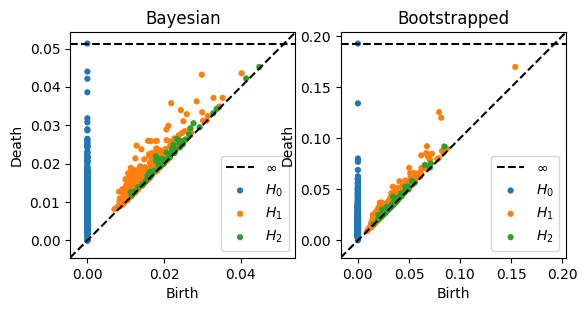

Bottleneck distance:
[0.06730832159519196, 0.023069782182574272, 0.004181914031505585]


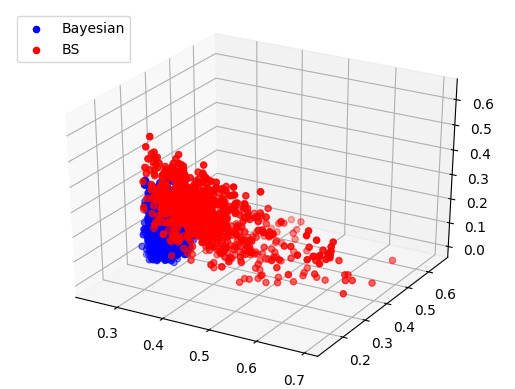

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f34d8122ac9d69c16f2e3e053229132 NOW.


Bayesian model for yeast type  Y130C
Inference for Stan model: anon_model_0f34d8122ac9d69c16f2e3e053229132.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1      0.37  7.1e-4   0.02   0.33   0.35   0.37   0.38   0.41    814    1.0
P2      0.27  8.6e-4   0.02   0.23   0.25   0.27   0.28   0.32    786    1.0
Pi      0.14  2.3e-3   0.06   0.02   0.09   0.14   0.18   0.26    754    1.0
sigma   0.08  1.3e-4 5.8e-3   0.07   0.08   0.08   0.09    0.1   1869    1.0
lp__  208.58    0.05   1.36 205.03 207.97 208.84 209.58 210.27    750    1.0

Samples were drawn using NUTS at Mon Apr 22 13:53:45 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


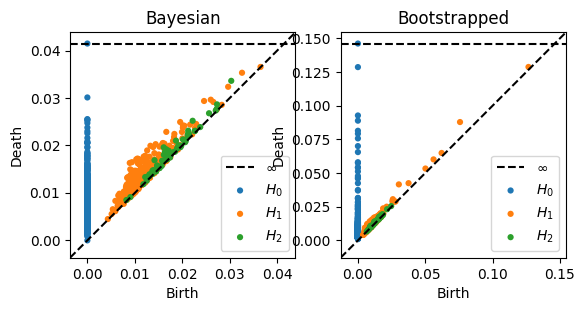

Bottleneck distance:
[0.06468754261732101, 0.006036316975951195, 0.0016585360281169415]


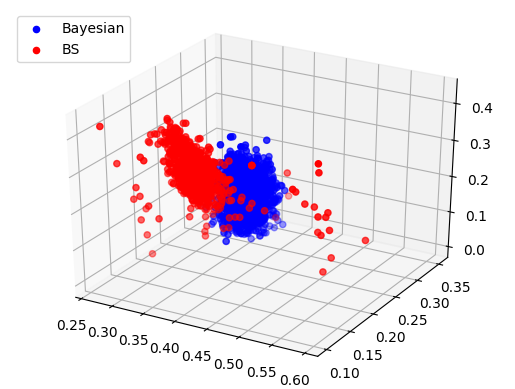

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f34d8122ac9d69c16f2e3e053229132 NOW.


Bayesian model for yeast type  F53S
Inference for Stan model: anon_model_0f34d8122ac9d69c16f2e3e053229132.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1      0.42  9.9e-4   0.03   0.37    0.4   0.42   0.44   0.49    883    1.0
P2      0.26  9.2e-4   0.03   0.21   0.24   0.26   0.27   0.31    743    1.0
Pi      0.15  2.5e-3   0.07   0.02    0.1   0.15   0.19   0.27    712    1.0
sigma    0.1  1.7e-4 6.6e-3   0.09   0.09    0.1    0.1   0.11   1538    1.0
lp__  192.26    0.05   1.28 188.99  191.6 192.55 193.22  193.9    673   1.01

Samples were drawn using NUTS at Mon Apr 22 13:59:56 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


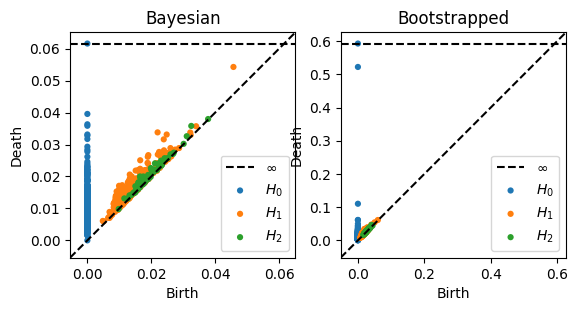

Bottleneck distance:
[0.2619852125644684, 0.0052914987318217754, 0.002777949906885624]


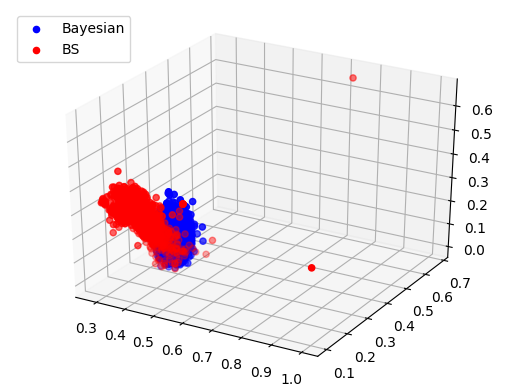

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0f34d8122ac9d69c16f2e3e053229132 NOW.


Bayesian model for yeast type  E203K
Inference for Stan model: anon_model_0f34d8122ac9d69c16f2e3e053229132.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
P1      0.67  2.9e-3   0.09   0.52   0.61   0.66   0.71   0.88    927    1.0
P2      0.38  2.4e-3   0.06   0.28   0.33   0.37   0.41   0.52    596   1.01
Pi      0.27  3.7e-3    0.1   0.05    0.2   0.27   0.34   0.45    756    1.0
sigma   0.14  2.5e-4 9.8e-3   0.12   0.13   0.14   0.14   0.16   1477    1.0
lp__  156.97    0.05   1.47  153.2 156.29 157.31 158.07 158.79    748   1.01

Samples were drawn using NUTS at Mon Apr 22 14:06:16 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


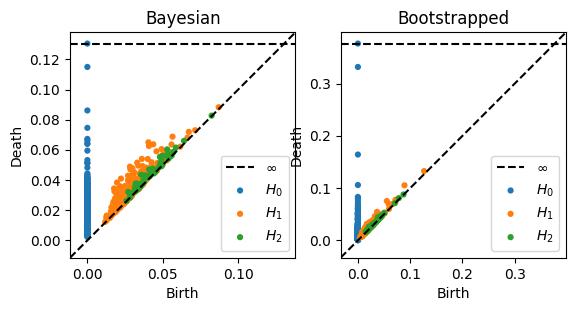

Bottleneck distance:
[0.1659998893737793, 0.010905498638749123, 0.0037275594659149647]


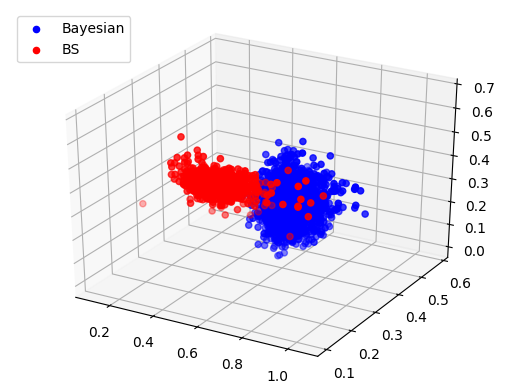

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

y_type = ['Wild Type', 'Y130C', 'F53S', 'E203K']

for i in range(len(y_type)):
  fit = stan_model_yd(bayes_td[i])
  
  print('\n Bayesian model for yeast type', y_type[i], ':')
  print(fit)

  posterior = fit.extract()
  bayes_data = np.stack([posterior['P1'], posterior['P2'], posterior['Pi']])
  bayes_data = np.swapaxes(bayes_data, 0, 1)

  bayes_pd = ripser(bayes_data[0:800], maxdim = 2)
  
  plt.title(y_type[i])
  plt.subplot(1, 2, 1)
  plot_diagrams(bayes_pd['dgms'], title='Bayesian')

  bs_pd = ripser(bs_data[i][0:800], maxdim = 2)
  
  plt.subplot(1, 2, 2)
  plot_diagrams(bs_pd['dgms'], title='Bootstrapped')
  plt.show()
  
  print('Bottleneck distance:')
  print(bottleneck_distance(bs_pd['dgms'], bayes_pd['dgms']))
  
  fig = plt.figure()
  
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(posterior['P1'], posterior['P2'], posterior['Pi'], c = 'b', marker='o', label='Bayesian')
  ax.scatter(bs_data[i][:, 0], bs_data[i][:, 1], bs_data[i][:, 2], c = 'r', marker='o', label='BS')
  ax.legend(loc='upper left')
  ax.set_xlabel('P1')
  ax.set_ylabel('P2')
  ax.set_zlabel('Pi')
  ax.title(y_type[i])

  plt.show()
  

In [30]:
print(bottleneck_distance(bs_pd['dgms'], bayes_pd['dgms']))

[0.16590477526187897, 0.010889558121562004, 0.003698974847793579]


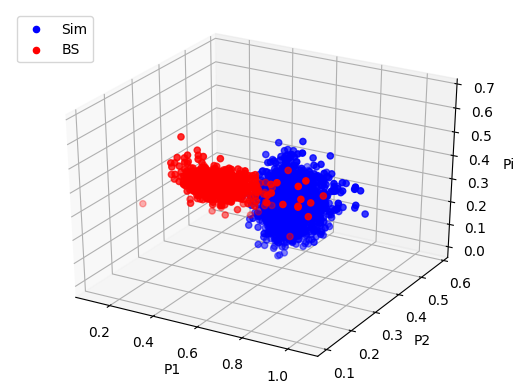

In [25]:
#Scatter plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(posterior['P1'], posterior['P2'], posterior['Pi'], c = 'b', marker='o', label='Sim')
ax.scatter(bs_data[3][:, 0], bs_data[3][:, 1], bs_data[3][:, 2], c = 'r', marker='o', label='BS')
ax.legend(loc='upper left')
ax.set_xlabel('P1')
ax.set_ylabel('P2')
ax.set_zlabel('Pi')
plt.show()

In [0]:
#Calculate the bottleneck distance between two (multi-dimensional) PDs

def bottleneck_distance(dgm1, dgm2):
  dim = len(dgm1)
  
  distance = []
  
  for i in range(dim):
    #dgm1_this_dim = dionysus.Diagram(dgm1[i])
    #dgm2_this_dim = dionysus.Diagram(dgm2[i])

    distance.append(bottleneck(dgm1[i], dgm2[i]))
    
  return distance